In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import sys

import pandas as pd
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformer_lens import utils as tl_utils
from transformer_lens import HookedTransformer
from collections import defaultdict
from tqdm.auto import tqdm
import einops

/data/phillip_guo/miniconda3/envs/cb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import GPT2Tokenizer, GPTNeoXTokenizerFast, AutoModelForCausalLM, AutoTokenizer, AutoConfig
from peft import PeftModel, AutoPeftModelForCausalLM, PeftConfig, get_peft_model
# model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct" 
base_model_name_or_path = "meta-llama/Meta-Llama-3-8B-Instruct"
pretrained_probe_type = "linear"
model_name_or_path = f"lora_train_llama3_8b_linear_use_sftTrue_num_steps150_seqinput_advoutput_pgd4_8_12_16_20_eps1.0"
run_id = "or_train_lat_sft"
# model_name_or_path = "/data/phillip_guo/circuit-breakers/harmfulness_probe/llama_lora_trained_full_kl"
model_type = "llama3_8b" # 
# model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.2"
# model_type = "mistral_7b"
lora_trained = True
check_pretrained_loras_only = True
if lora_trained:
    # config = PeftConfig.from_pretrained(model_name_or_path)
    model = AutoPeftModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16,
                                      low_cpu_mem_usage=True,
                                      device_map="cuda",
                                      trust_remote_code=True)
    # model = AutoModelForCausalLM.from_pretrained(base_model_name_or_path, torch_dtype=torch.bfloat16,          
    #             low_cpu_mem_usage=True,
    #             device_map="cuda",
    #             trust_remote_code=True,)
    # model = get_peft_model(model, config)
    # model.load_adapter(model_name_or_path)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16,          
                low_cpu_mem_usage=True,
                # attn_implementation="flash_attention_2",
                device_map="cuda",
                trust_remote_code=True,)
tokenizer = AutoTokenizer.from_pretrained(base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

class Config:
    def __init__(self, n_layers, n_heads, d_model):
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.d_model = d_model

model.cfg = Config(n_layers=32, n_heads=32, d_model=4096)

# if model_name_or_path == "mistralai/Mistral-7B-Instruct-v0.1":
#     real_model_name = "mistralai/Mistral-7B-Instruct-v0.2"
#     real_model = AutoModelForCausalLM.from_pretrained(real_model_name, torch_dtype=torch.bfloat16)
save_dir = f"full_input_output_cache_{model_type}{f'_lora_trained_{pretrained_probe_type}' if lora_trained else ''}{f'_{run_id}' if run_id is not None else ''}"
os.makedirs(save_dir, exist_ok=True)
# os.makedirs(save_dir, exist_ok=True)
# os.makedirs(f"{save_dir}/harm_scores", exist_ok=True)
# model = HookedTransformer.from_pretrained(
#     model_name_or_path,
#     device='cuda',
#     default_padding_side="left",
#     fold_ln=False,
#     fold_value_biases=False,
#     center_writing_weights=False,
#     dtype=torch.bfloat16,
#     # hf_model=real_model
# )
# n_layers = model.cfg.n_layers
# tokenizer = model.tokenizer


cache_layers = [10, 20, 31]

Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


In [3]:
if lora_trained:
    class MLP(torch.nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super().__init__()
            self.fc1 = torch.nn.Linear(input_size, hidden_size)

            # for 1 layer:
            self.fc2 = torch.nn.Linear(hidden_size, output_size)

            # # for 2 layers
            # self.fc2 = torch.nn.Linear(hidden_size, hidden_size // 2)
            # self.fc3 = torch.nn.Linear(hidden_size // 2, output_size)

            self.relu = torch.nn.ReLU()

        def forward(self, x):
            x = self.relu(self.fc1(x))

            # for 1 layer
            return self.fc2(x)

            # # for 2 layers
            # x = self.relu(self.fc2(x))
            # return self.fc3(x)

    class Linear(torch.nn.Module):
        def __init__(self, input_size, output_size):
            super().__init__()
            self.fc = torch.nn.Linear(input_size, output_size)

        def forward(self, x):
            return self.fc(x)


    class Scale(torch.nn.Module):
        def __init__(self, m, scale: float = 100):
            super().__init__()
            self.m = m
            self.scale = torch.nn.Parameter(torch.tensor(1.0))

        def forward(self, x):
            return self.m(x) * self.scale

    def zero_init(m):
        # if isinstance(m, torch.nn.Linear):
        #     m.weight.data.zero_()
        #     if m.bias is not None:
        #         m.bias.data.zero_()
        for name, p in m.named_parameters():
            p.data.zero_()
        return m

    # probes saved with this code:
    # if probes is not None:
    #     torch.save({name: probe.state_dict() for name, probe in zip(range(len(probes)), probes)}, os.path.join(output_dir, "probes.pt"))
    #     print("saved probes file to output directory.")
    try:
        pretrained_probes = torch.load(os.path.join(model_name_or_path, "probe_dict.pt")) 
    except:
        print("Probes not found in local directory, downloading from Hugging Face Hub...")
        from huggingface_hub import hf_hub_download
        probes_path = hf_hub_download(repo_id=model_name_or_path, filename="probe_dict.pt")
        print(probes_path)
        pretrained_probes = torch.load(probes_path)

    # pretrained_probes = {}

    # # pretrained_probes = {layer: 
    # #                 Scale(zero_init(MLP(model.cfg.d_model, 32, 1)))
    # #                 for layer in cache_layers}
    # for layer_i in cache_layers:
    #     # probe_dict[layer_i] = Scale(zero_init(MLP(model.cfg.d_model, hidden_size, 1))).cuda()
    #     if pretrained_probe_type == "mlp":
    #         print("Using MLP probe")
    #         pretrained_probes[layer_i] = Scale(MLP(model.cfg.d_model, 32, 1)).cuda()
    #     elif pretrained_probe_type == "linear":
    #         print("Using Linear probe")
    #         pretrained_probes[layer_i] = Scale(Linear(model.cfg.d_model, 1)).cuda()
    #     else:
    #         raise ValueError(f"Probe type {pretrained_probe_type} not recognized")
    # for layer in cache_layers:
        # pretrained_probes[layer].load_state_dict(pretrained_probes_state_dict[layer])
    for layer in cache_layers:
        pretrained_probes[layer].cuda()


/tmp/ipykernel_2082086/2327814552.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_probes = torch.load(os.path.join(model_name_or_path, "probe_dict.pt"))


In [4]:
from eval_harmful_probes import *

all_prompts, in_distribution_formal_names, out_distribution_formal_names = load_data(model_type=model_type, tokenizer=tokenizer, eval_only=True, abhay_jailbreaks=True)
print(all_prompts.keys())

dict_keys(['ultrachat_test', 'circuit_breakers_test', 'mt_bench', 'or_bench', 'wildchat', 'GCG_test', 'Human_Multiturn_test', 'PAIR_test', 'AutoDAN_test', 'DirectRequest_test', 'TAP_Transfer_test', 'HumanJailbreaks_test'])


In [5]:
out_distribution_formal_names

{'GCG_test': 'GCG',
 'Human_Multiturn_test': 'Human Multiturn',
 'AutoDAN_test': 'AutoDAN',
 'PAIR_test': 'PAIR',
 'DirectRequest_test': 'Direct Request',
 'TAP_Transfer_test': 'TAP Transfer',
 'HumanJailbreaks_test': 'Human Jailbreaks',
 'circuit_breakers_test': 'Circuit Breakers Test'}

In [6]:
all_caches, cache_ranges = get_acts_and_ranges(model=model, tokenizer=tokenizer, cache_layers=cache_layers, all_prompts=all_prompts, batch_size=12)

Retrieving cache for ultrachat_test


  0%|          | 0/42 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
100%|██████████| 42/42 [01:09<00:00,  1.67s/it]


Done caching
Retrieving cache for circuit_breakers_test


100%|██████████| 42/42 [00:31<00:00,  1.32it/s]


Done caching
Retrieving cache for mt_bench


100%|██████████| 80/80 [00:06<00:00, 11.68it/s]


Done caching
Retrieving cache for or_bench


100%|██████████| 42/42 [00:20<00:00,  2.06it/s]


Done caching
Retrieving cache for wildchat


100%|██████████| 125/125 [02:23<00:00,  1.15s/it]


Done caching
Retrieving cache for GCG_test


100%|██████████| 8/8 [00:09<00:00,  1.15s/it]


Done caching
Retrieving cache for Human_Multiturn_test


100%|██████████| 86/86 [00:20<00:00,  4.24it/s]


Done caching
Retrieving cache for PAIR_test


100%|██████████| 22/22 [00:13<00:00,  1.69it/s]


Done caching
Retrieving cache for AutoDAN_test


100%|██████████| 17/17 [00:27<00:00,  1.62s/it]


Done caching
Retrieving cache for DirectRequest_test


100%|██████████| 3/3 [00:04<00:00,  1.37s/it]


Done caching
Retrieving cache for TAP_Transfer_test


100%|██████████| 4/4 [00:06<00:00,  1.51s/it]


Done caching
Retrieving cache for HumanJailbreaks_test


100%|██████████| 20/20 [00:03<00:00,  5.38it/s]


Done caching


In [10]:
in_distribution_probe_scores = {
    name: predict_aggregate_pretrained_probe(mlp_probes=pretrained_probes, caches=all_caches[name], indices=cache_layers, cache_type="output", cache_name=name, use_logprobs=True, on_cuda=True, batch_size=256, cache_ranges=cache_ranges) for name in in_distribution_formal_names
}
out_distribution_probe_scores = {
    name: predict_aggregate_pretrained_probe(mlp_probes=pretrained_probes, caches=all_caches[name], indices=cache_layers, cache_type="output", cache_name=name, use_logprobs=True, on_cuda=True, batch_size=256, cache_ranges=cache_ranges) for name in out_distribution_formal_names
}

100%|██████████| 500/500 [00:00<00:00, 936.47it/s]


In [14]:
torch.cat(in_distribution_probe_scores['ultrachat_test'], dim=1).shape

torch.Size([3, 157496, 1])

100%|██████████| 500/500 [00:00<00:00, 928.39it/s]


Aggregating max max {}


/data/phillip_guo/sae_experiments/eval_harmful_probes.py:578: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  harm_scores = torch.tensor(harm_scores).flatten() # flatten too, for multiple indices


Aggregating log_softmax log_softmax {}


/data/phillip_guo/sae_experiments/eval_harmful_probes.py:578: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  harm_scores = torch.tensor(harm_scores).flatten() # flatten too, for multiple indices


Aggregating vickrey_k vickrey {'vickrey_k': 10}


/data/phillip_guo/sae_experiments/eval_harmful_probes.py:578: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  harm_scores = torch.tensor(harm_scores).flatten() # flatten too, for multiple indices


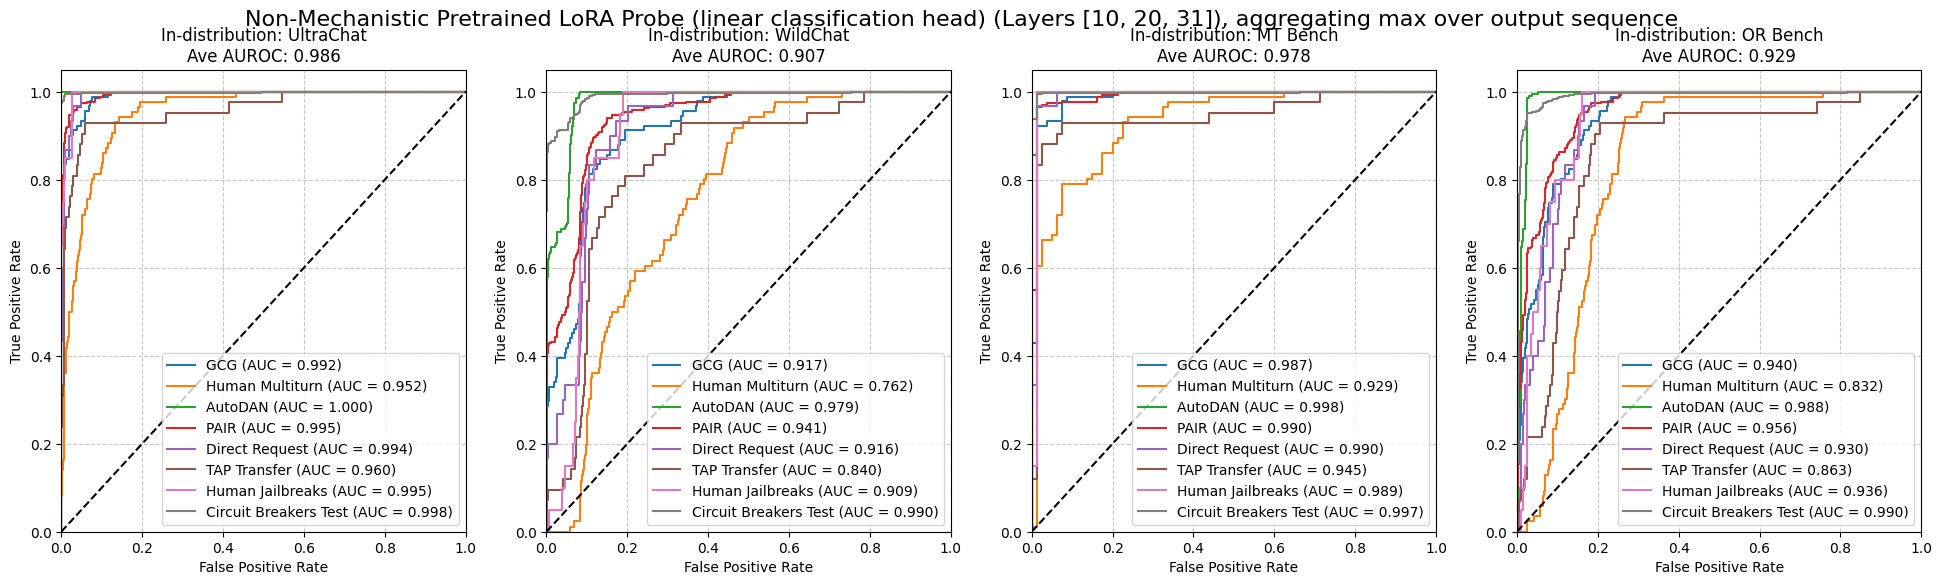

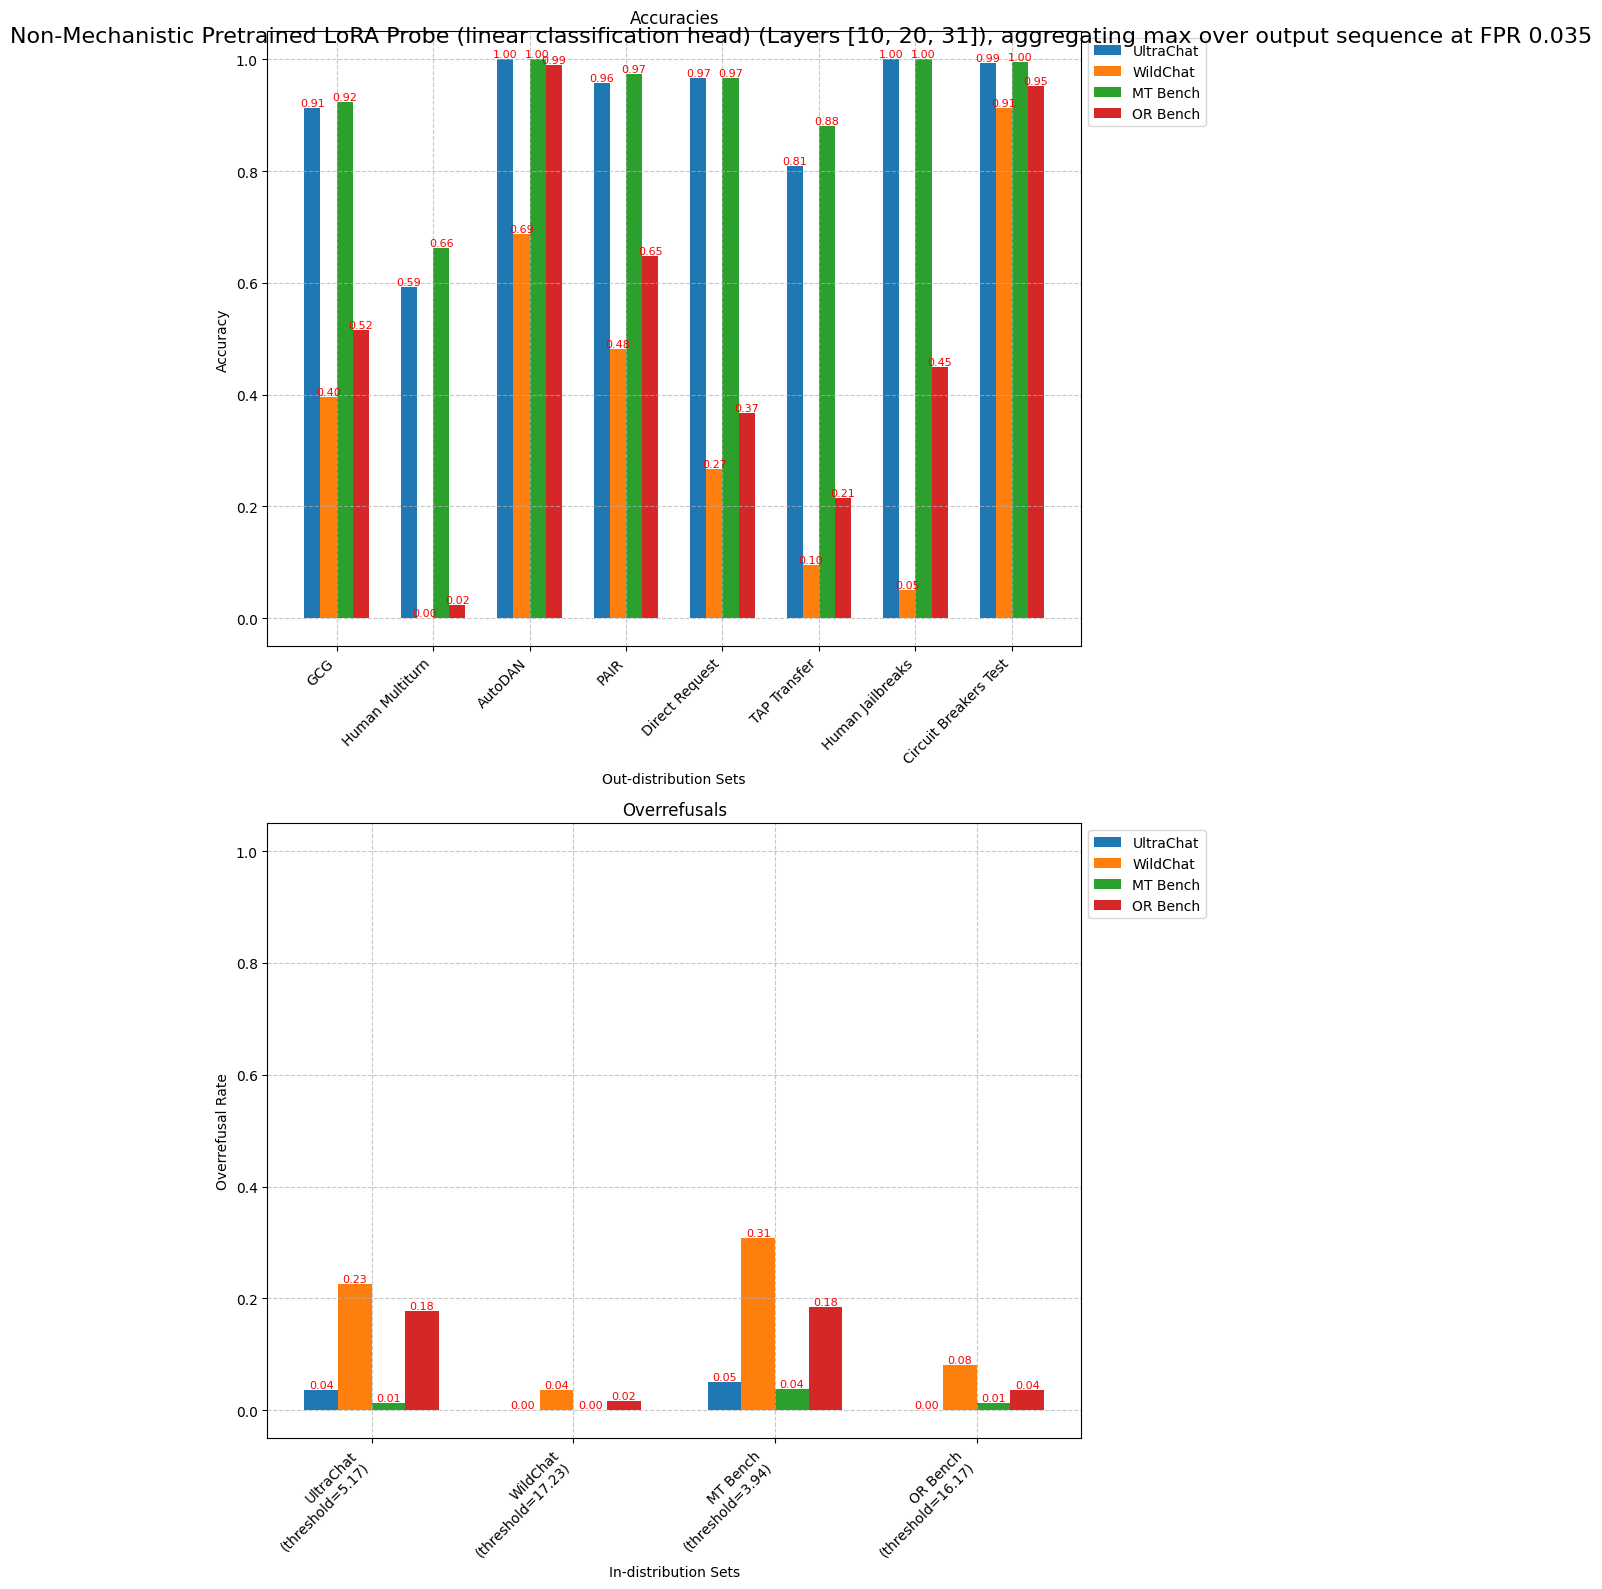

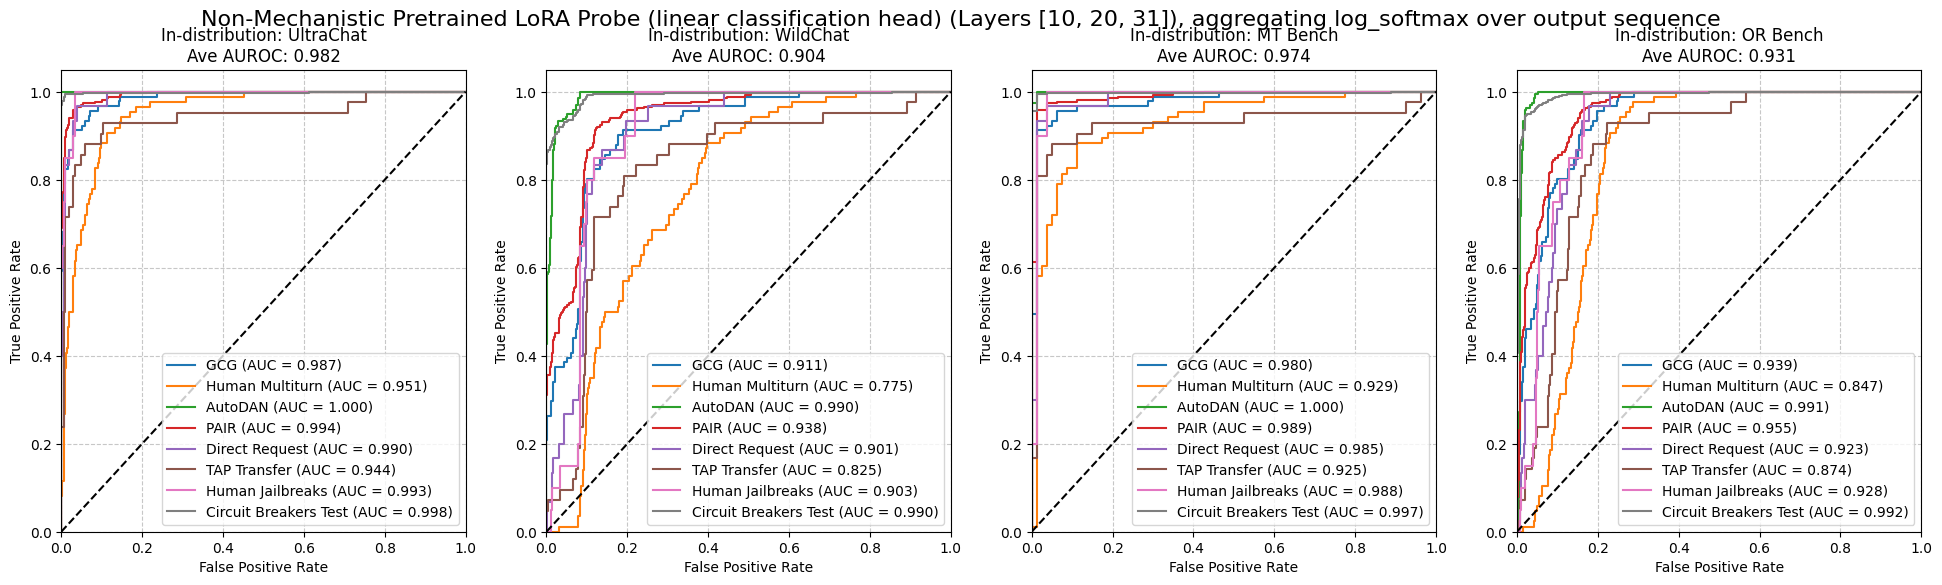

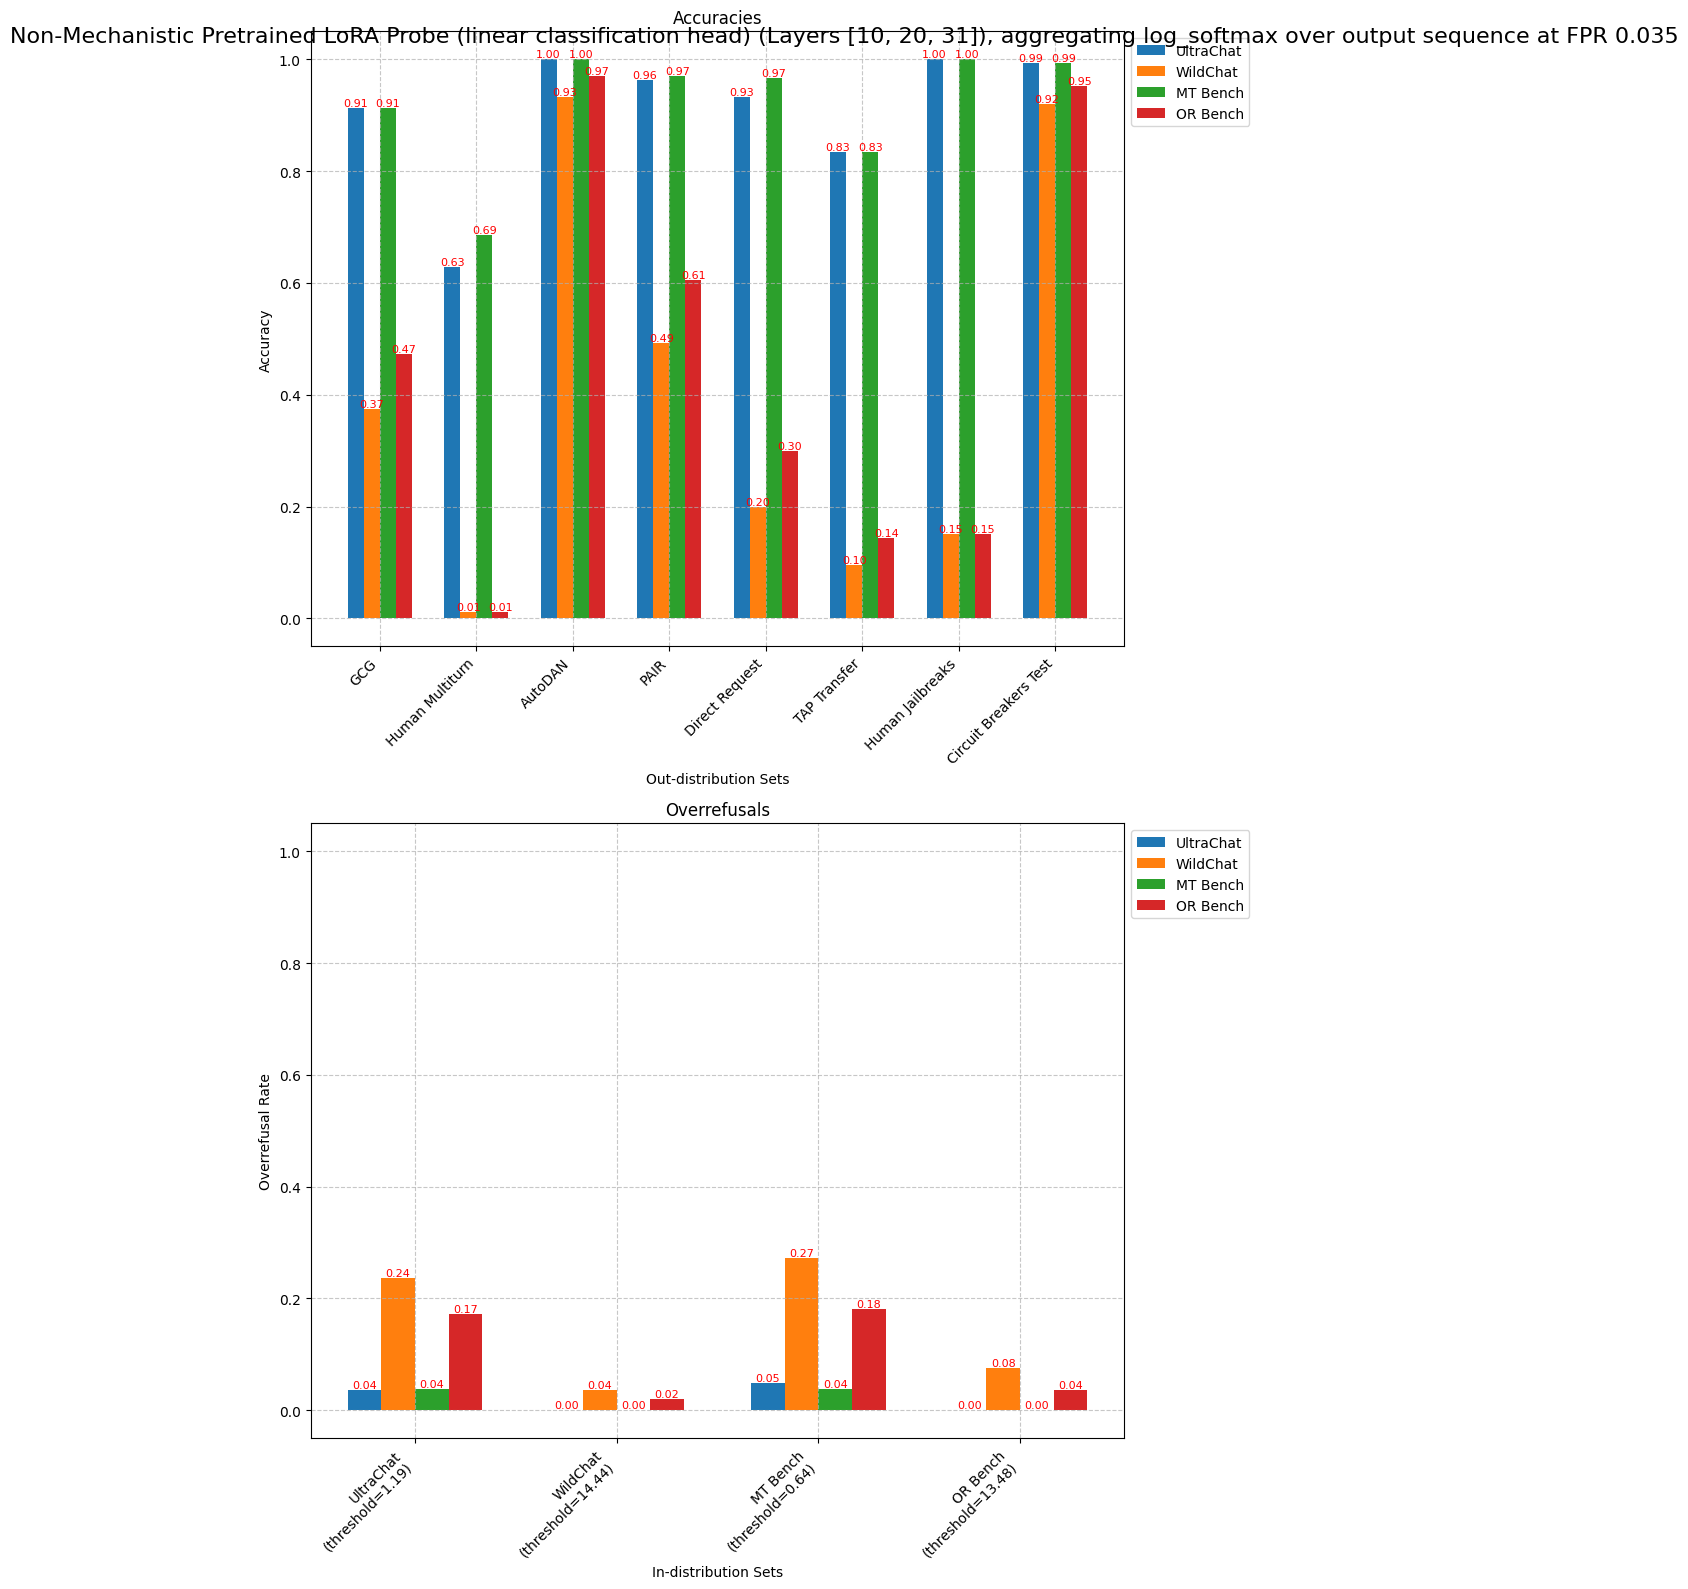

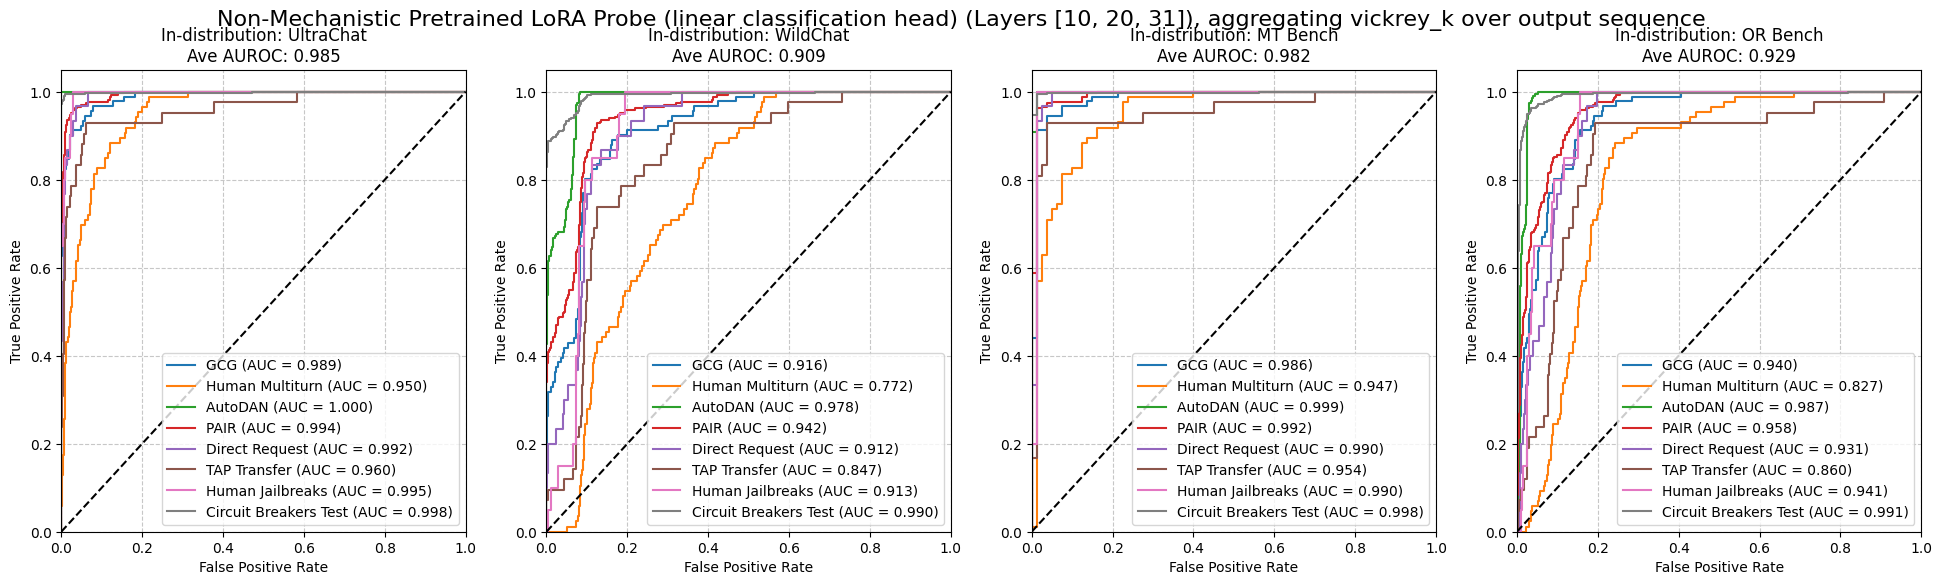

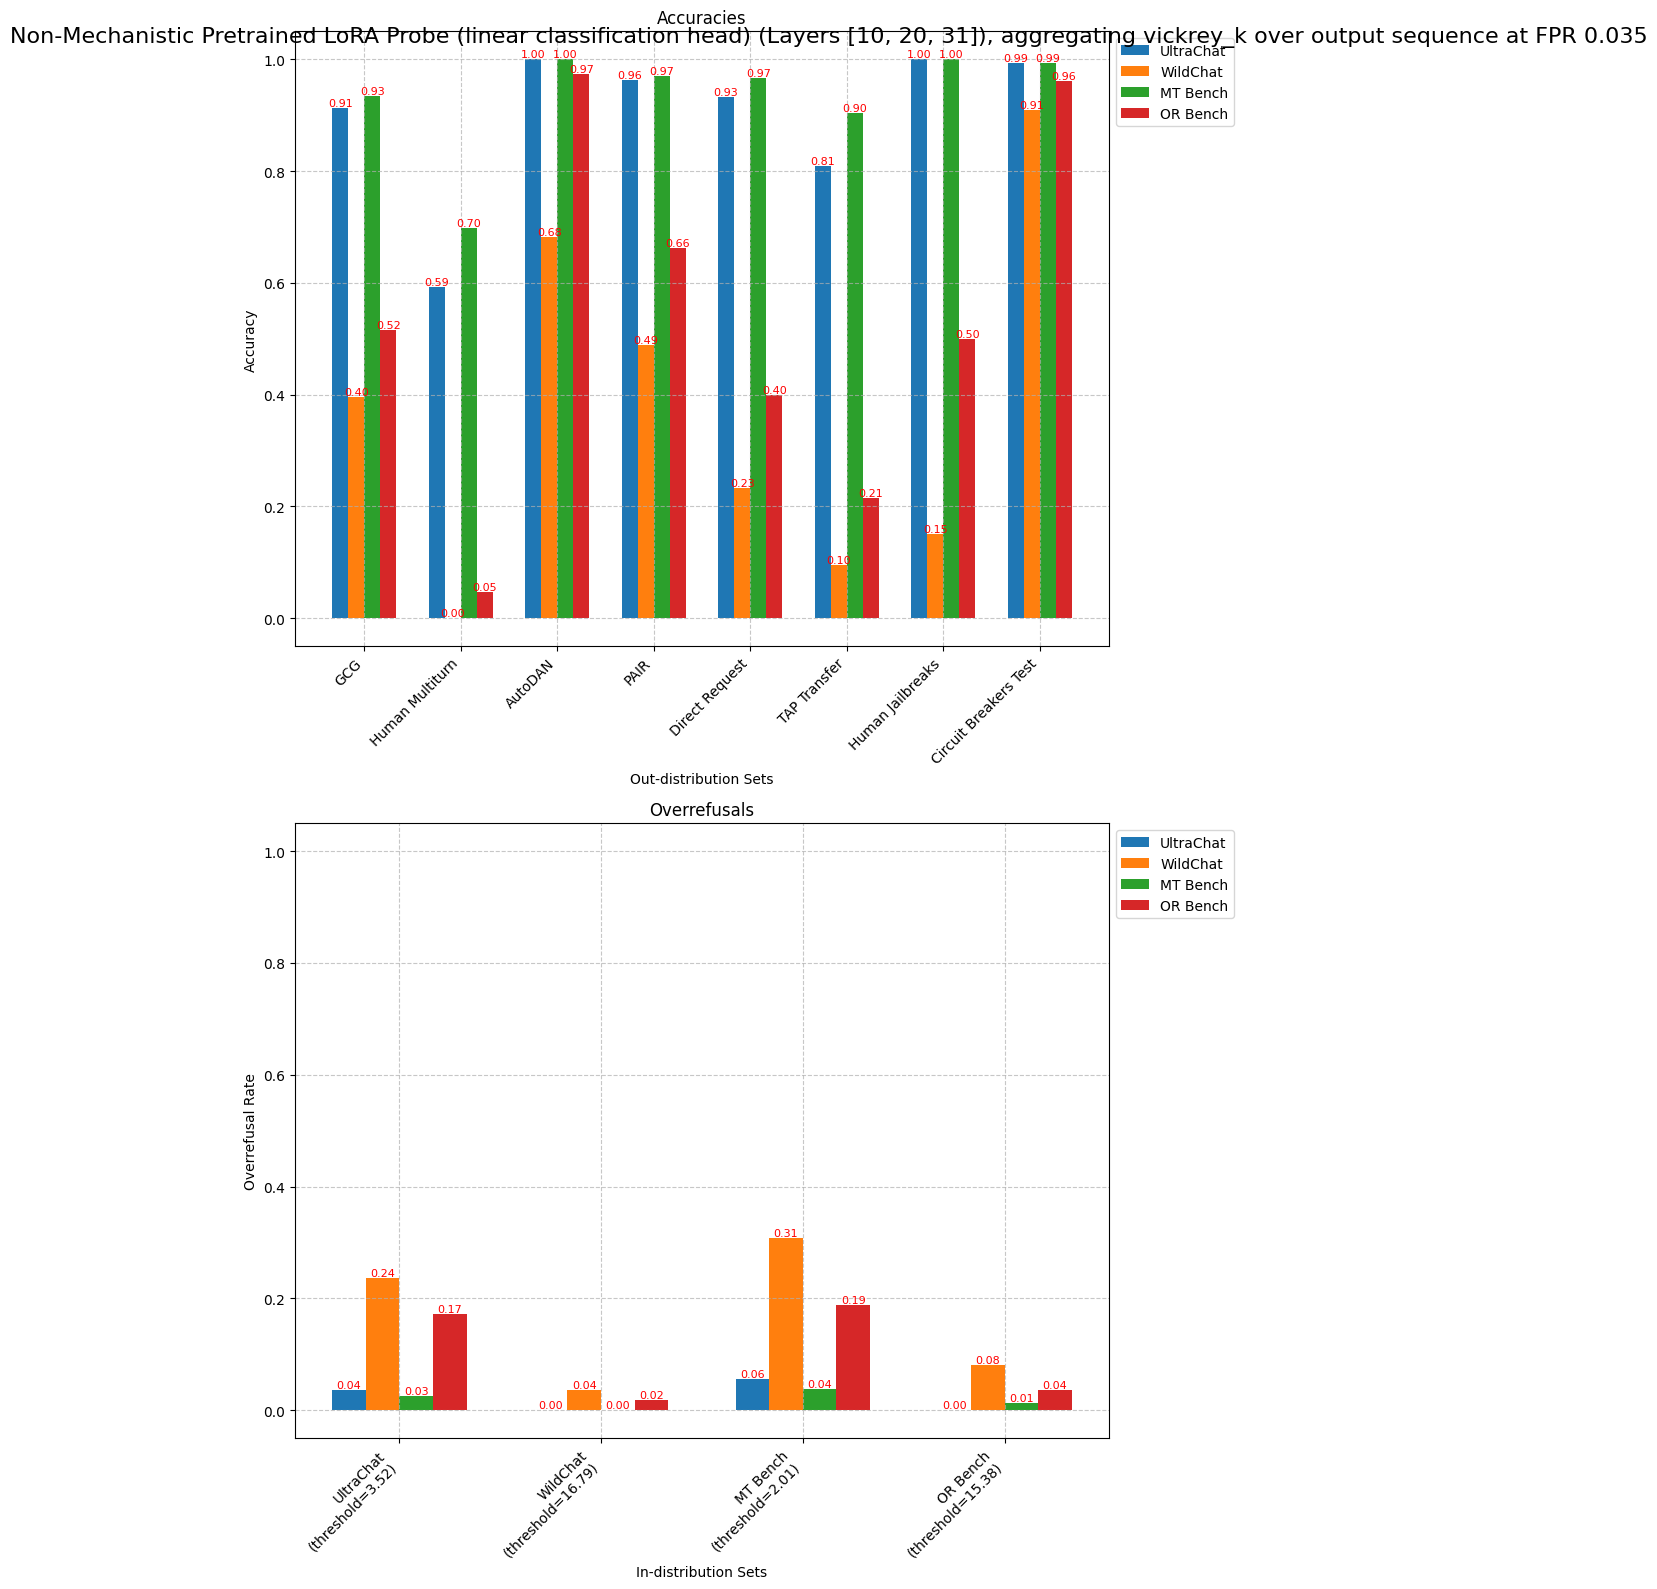

In [9]:
eval_pretrained_probe(pretrained_probes, caches=all_caches, non_mechanistic_layers=cache_layers, cache_type="output", cache_ranges=cache_ranges, in_distribution_formal_names=in_distribution_formal_names, out_distribution_formal_names=out_distribution_formal_names, save_dir=f"{save_dir}/figures_abhay")